In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
from scipy.misc import imresize

%matplotlib inline

import os
from os import listdir
from os.path import isfile, join
import shutil
import stat
import collections
from collections import defaultdict

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

import h5py
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.applications.inception_v3 import preprocess_input
from keras.models import load_model

Using TensorFlow backend.


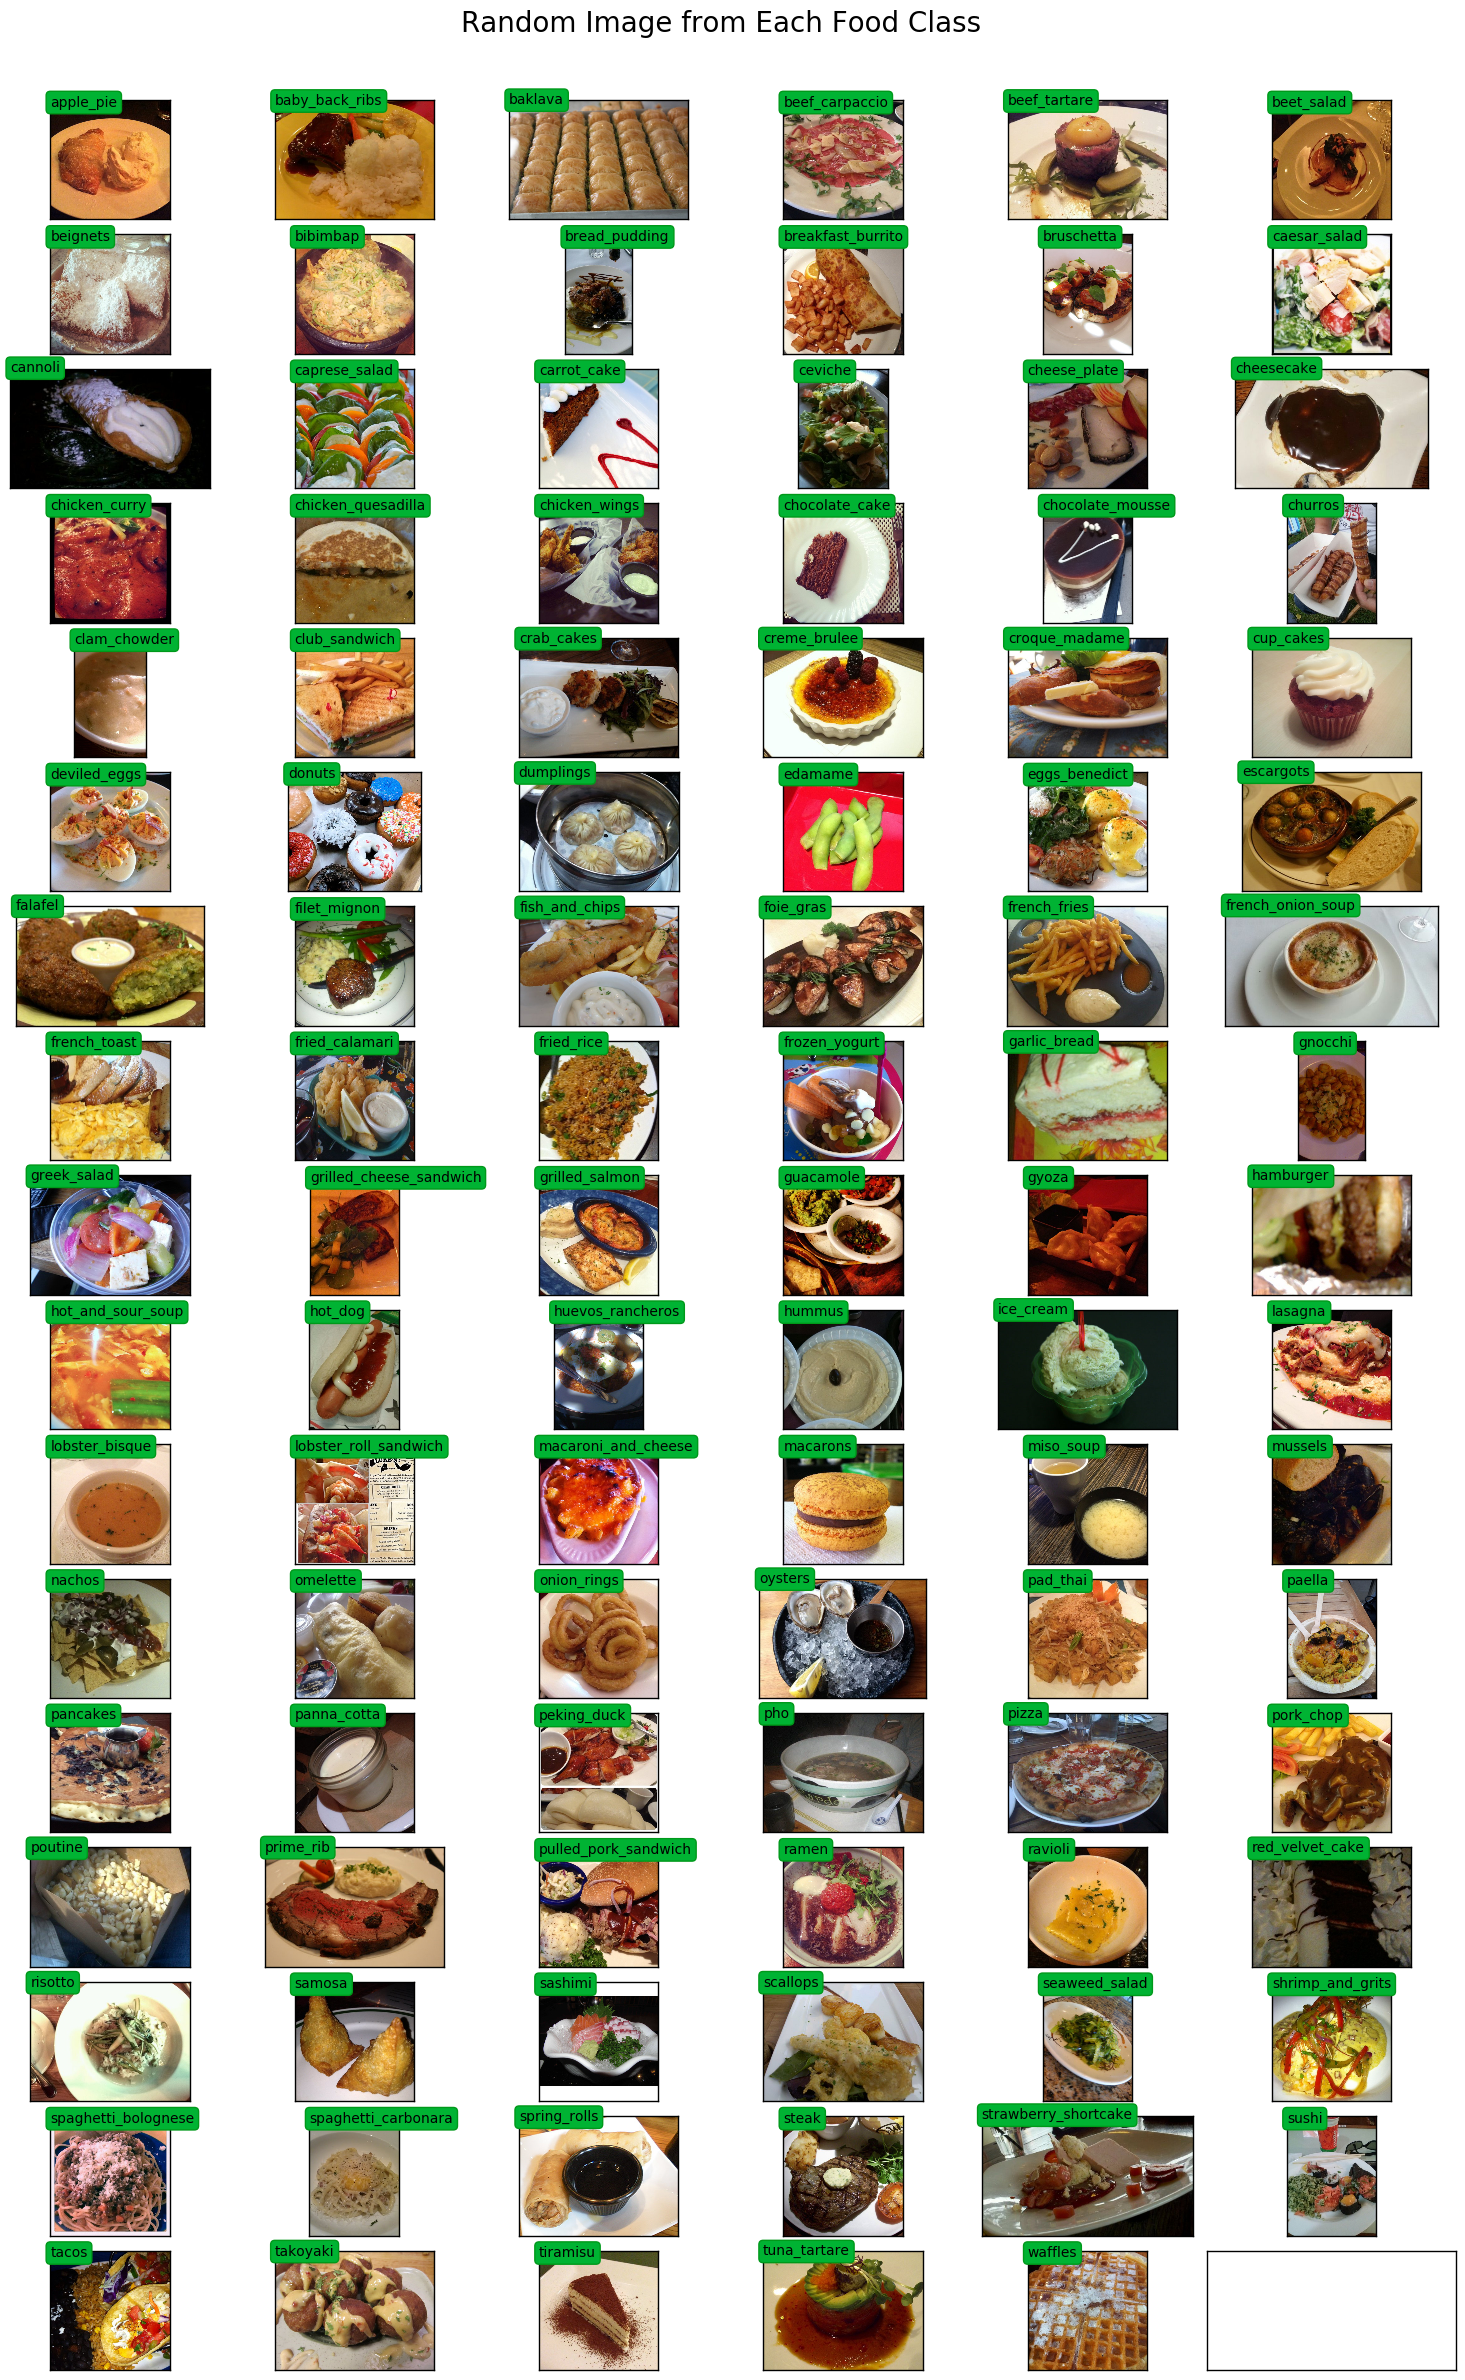

In [2]:
root_dir = 'food-101/images/'
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25))
fig.suptitle('Random Image from Each Food Class', fontsize=20)
sorted_food_dirs = sorted(os.listdir(root_dir))
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = sorted_food_dirs[i*cols + j]
        except:
            break
        all_files = os.listdir(os.path.join(root_dir, food_dir))
        rand_img = np.random.choice(all_files)
        img = plt.imread(os.path.join(root_dir, food_dir, rand_img))
        ax[i][j].imshow(img)
        ec = (0, .6, .1)
        fc = (0, .7, .2)
        ax[i][j].text(0, -20, food_dir, size=10, rotation=0,
                ha="left", va="top", 
                bbox=dict(boxstyle="round", ec=ec, fc=fc))
plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

In [3]:
# Setup multiprocessing pool
# Do this early, as once images are loaded into memory there will be Errno 12
# http://stackoverflow.com/questions/14749897/python-multiprocessing-memory-usage
import multiprocessing as mp

num_processes = 6
pool = mp.Pool(processes=num_processes)

In [11]:
class_to_ix = {}
ix_to_class = {}
with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [12]:
if not os.path.isdir('./food-101/test') and not os.path.isdir('./food-101/train'):

    def copytree(src, dst, symlinks = False, ignore = None):
        if not os.path.exists(dst):
            os.makedirs(dst)
            shutil.copystat(src, dst)
        lst = os.listdir(src)
        if ignore:
            excl = ignore(src, lst)
            lst = [x for x in lst if x not in excl]
        for item in lst:
            s = os.path.join(src, item)
            d = os.path.join(dst, item)
            if symlinks and os.path.islink(s):
                if os.path.lexists(d):
                    os.remove(d)
                os.symlink(os.readlink(s), d)
                try:
                    st = os.lstat(s)
                    mode = stat.S_IMODE(st.st_mode)
                    os.lchmod(d, mode)
                except:
                    pass # lchmod not available
            elif os.path.isdir(s):
                copytree(s, d, symlinks, ignore)
            else:
                shutil.copy2(s, d)

    def generate_dir_file_map(path):
        dir_files = defaultdict(list)
        with open(path, 'r') as txt:
            files = [l.strip() for l in txt.readlines()]
            for f in files:
                dir_name, id = f.split('/')
                dir_files[dir_name].append(id + '.jpg')
        return dir_files

    train_dir_files = generate_dir_file_map('food-101/meta/train.txt')
    test_dir_files = generate_dir_file_map('food-101/meta/test.txt')


    def ignore_train(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = train_dir_files[subdir]
        return to_ignore

    def ignore_test(d, filenames):
        print(d)
        subdir = d.split('/')[-1]
        to_ignore = test_dir_files[subdir]
        return to_ignore

    copytree('food-101/images', 'food-101/test', ignore=ignore_train)
    copytree('food-101/images', 'food-101/train', ignore=ignore_test)
    
else:
    print('Train/Test files already copied into separate folders.')

Train/Test files already copied into separate folders.


In [ ]:
%%time
import matplotlib.image as img

# Load dataset images and resize to meet minimum width and height pixel size
def load_images(root, min_side=299):
    all_imgs = []
    all_classes = []
    resize_count = 0
    invalid_count = 0
    for i, subdir in enumerate(listdir(root)):
        imgs = listdir(join(root, subdir))
        class_ix = class_to_ix[subdir]
        print(i, class_ix, subdir)
        for img_name in imgs:
            img_arr = img.imread(join(root, subdir, img_name))
            img_arr_rs = img_arr
            try:
                w, h, _ = img_arr.shape
                if w < min_side:
                    wpercent = (min_side/float(w))
                    hsize = int((float(h)*float(wpercent)))
                    #print('new dims:', min_side, hsize)
                    img_arr_rs = imresize(img_arr, (min_side, hsize))
                    resize_count += 1
                elif h < min_side:
                    hpercent = (min_side/float(h))
                    wsize = int((float(w)*float(hpercent)))
                    #print('new dims:', wsize, min_side)
                    img_arr_rs = imresize(img_arr, (wsize, min_side))
                    resize_count += 1
                all_imgs.append(img_arr_rs)
                all_classes.append(class_ix)
            except:
                print('Skipping bad image: ', subdir, img_name)
                invalid_count += 1
    print(len(all_imgs), 'images loaded')
    print(resize_count, 'images resized')
    print(invalid_count, 'images skipped')
    return np.array(all_imgs), np.array(all_classes)
    
X_test, y_test = load_images('food-101/test', min_side=299)

(0, 1, 'baby_back_ribs')
(1, 80, 'pulled_pork_sandwich')
(2, 39, 'foie_gras')
(3, 76, 'pizza')
(4, 13, 'caprese_salad')
(5, 5, 'beet_salad')
(6, 73, 'panna_cotta')
(7, 98, 'tiramisu')
(8, 19, 'chicken_quesadilla')
(9, 94, 'strawberry_shortcake')
(10, 20, 'chicken_wings')
(11, 93, 'steak')
(12, 59, 'lasagna')
(13, 64, 'miso_soup')
(14, 91, 'spaghetti_carbonara')
(15, 52, 'gyoza')
(16, 83, 'red_velvet_cake')
(17, 68, 'onion_rings')
(18, 35, 'escargots')
(19, 50, 'grilled_salmon')
(20, 99, 'tuna_tartare')
(21, 65, 'mussels')
(22, 26, 'crab_cakes')
(23, 62, 'macaroni_and_cheese')
